In [82]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from datetime import datetime

# Configure matplotlib for LaTeX rendering
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman'],
    'font.size': 20,
    'axes.labelsize': 25,
    'axes.titlesize': 25,
    'legend.fontsize': 25,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'figure.titlesize': 30,
    'pgf.rcfonts': False,  # Use LaTeX default fonts for PGF
    'pgf.preamble': r'\usepackage{amsmath}\usepackage{amsfonts}'
})

from plot.multicurve import MultiCurvePlotter
from plot.log_dual_plot import LogDualPlot

from core.nodes.transmission_node import TransmissionNode
from core.nodes.computing_node import ComputingNode

# Partial Offloading

- Computing on User Satellite in Offloading case
- Variation of $\phi_\text{ec}$
- Ratio $S_\text{isl} / S_\text{gl}$

In [83]:
with_legend = True
plot_precision = 1000

data_size = 100
phi_min = 0.0  # Minimum phi value
phi_max = 1.5  # Maximum phi value

# Base Case - calculate reference costs
base_time_cost = 0
base_energy_cost = 0

In [84]:
config = {
    "base": {
        "obdh": {
            "speed": 30.0,
            "phi": 0.9,
            "energy_uptime": 1,
            "energy_io": 0.001
        },
        "ground_link": {
            "speed": 10.0,
            "energy": 5,
            "distance": 700
        }
    },
    "offloading": {
        "user_satellite": {
            "obdh": {
                "speed": 30.0,
                "phi": 0.9,
                "energy_uptime": 1,
                "energy_io": 0.001
            },
            "isl": {
                "speed": None, # Exploring ISL speed variation
                "energy": 3,
                "distance": 100
            }
        },
        "edge_node": {
            "edge_computer": {
                "phi": None, # Exploring EC phi variation
                "speed": 300.0,
                "energy_uptime": 50,
                "energy_io": 0.001
            },
            "ground_link": {
                "speed": None, # Exploring GL speed variation
                "energy": 5,
                "distance": 700
            }
        }
    }
}

# Base Case

- Computing on User Satellite (OBDH)
- Ground Link

In [85]:
base_obdh_speed = config['base']['obdh']['speed']
base_odbh_phi = config['base']['obdh']['phi']
base_obdh_energy_uptime = config['base']['obdh']['energy_uptime']
base_obdh_energy_io = config['base']['obdh']['energy_io']

obc = ComputingNode(
    speed=base_obdh_speed,
    phi=base_odbh_phi
)

base_time_cost += obc.time_cost(data_size)
base_energy_cost += obc.energy_cost(
    data_size,
    energy_uptime=base_obdh_energy_uptime,
    energy_io=base_obdh_energy_io
)

d_out = obc.process(data_size)

base_ground_link_speed = config['base']['ground_link']['speed']
base_ground_link_energy = config['base']['ground_link']['energy']
base_ground_link_distance = config['base']['ground_link']['distance']

ground_link = TransmissionNode(
    speed=base_ground_link_speed
)

base_time_cost += ground_link.time_cost(d_out)
base_energy_cost += ground_link.energy_cost(
    d_out,
    energy=base_ground_link_energy,
    distance=base_ground_link_distance
)

print(f"Base case - Time: {base_time_cost:.3f}s, Energy: {base_energy_cost:.3f}J")

Base case - Time: 12.333s, Energy: 131.463J


In [86]:
# Create parameter grids
# x-axis: ISL/GL speed ratios (logarithmic), centered on base ground link speed
ratio_exponents = np.linspace(-1, 2, plot_precision)  # From 10^-2 to 10^2
ratios = 10 ** ratio_exponents
# y-axis: phi values for edge computer (linear)
phi_values = np.linspace(phi_min, phi_max, plot_precision)

# Create meshgrid for plotting
ratio_mesh, phi_mesh = np.meshgrid(ratios, phi_values)

print(f"Testing phi range: {phi_min} to {phi_max}")
print(f"Ratio range: {ratios[0]:.3f} to {ratios[-1]:.1f}")
print(f"Base ground link speed (reference): {base_ground_link_speed} Mb/s")
print(f"Grid size: {len(phi_values)} x {len(ratios)} = {len(phi_values) * len(ratios)} points")

# Initialize arrays to store results
time_costs = np.zeros_like(ratio_mesh)
energy_costs = np.zeros_like(ratio_mesh)

Testing phi range: 0.0 to 1.5
Ratio range: 0.100 to 100.0
Base ground link speed (reference): 10.0 Mb/s
Grid size: 1000 x 1000 = 1000000 points


# Offloading Case

- Computing on User Satellite
- ISL to Edge Node
- Computing on Edge Node
- Edge Node ground link

In [87]:
off_obdh_speed = config['offloading']['user_satellite']['obdh']['speed']
off_obdh_phi = config['offloading']['user_satellite']['obdh']['phi']
off_obdh_energy_uptime = config['offloading']['user_satellite']['obdh']['energy_uptime']
off_obdh_energy_io = config['offloading']['user_satellite']['obdh']['energy_io']

# Variation of Usr ISL
# isl_speed = config['offloading']['user_satellite']['isl']['speed']
off_isl_energy = config['offloading']['user_satellite']['isl']['energy']
off_isl_distance = config['offloading']['user_satellite']['isl']['distance']

off_edge_computer_speed = config['offloading']['edge_node']['edge_computer']['speed']
# Variation of EC phi
# edge_computer_phi = config['offloading']['edge_node']['edge_computer']['phi']
off_edge_computer_energy_uptime = config['offloading']['edge_node']['edge_computer']['energy_uptime']
off_edge_computer_energy_io = config['offloading']['edge_node']['edge_computer']['energy_io']

# Variation of EN gl
# off_ground_link_speed = config['offloading']['edge_node']['ground_link']['speed']
off_ground_link_energy = config['offloading']['edge_node']['ground_link']['energy']
off_ground_link_distance = config['offloading']['edge_node']['ground_link']['distance']

# Reusing the same User satellite node as in the base case
obdh = ComputingNode(
    speed=off_obdh_speed,
    phi=off_obdh_phi
)

offloading_time_cost = obc.time_cost(data_size)
offloading_energy_cost = obc.energy_cost(
    data_size,
    energy_uptime=off_obdh_energy_uptime,
    energy_io=off_obdh_energy_io
)

d_out = obdh.process(data_size)

print("Computing cost grid...")
for i, phi_val in enumerate(phi_values):
    if i % 10 == 0:
        print(f"Processing phi {i + 1}/{len(phi_values)}: {phi_val:.2f}")

    for j, ratio in enumerate(ratios):
        # Calculate ISL and GL speeds based on ratio and base ground link speed
        # Ground link speed is fixed to base case, ISL speed varies with ratio
        speed_gl = base_ground_link_speed
        speed_isl = ratio * base_ground_link_speed

        # ISL transmission
        isl = TransmissionNode(speed=float(speed_isl))
        iteration_time_cost = isl.time_cost(d_out)
        iteration_energy_cost = isl.energy_cost(
            d_out,
            energy=off_isl_energy,
            distance=off_isl_distance
        )

        # Edge computing with current phi value
        edge_computer = ComputingNode(
            speed=off_edge_computer_speed,
            phi=phi_val
        )

        iteration_time_cost += edge_computer.time_cost(d_out)
        iteration_energy_cost += edge_computer.energy_cost(
            d_out,
            energy_uptime=off_edge_computer_energy_uptime,
            energy_io=off_edge_computer_energy_io
        )

        d_out_ec = edge_computer.process(d_out)

        # Ground link transmission (fixed speed)
        ground_link = TransmissionNode(speed=float(speed_gl))
        iteration_time_cost += ground_link.time_cost(d_out_ec)
        iteration_energy_cost += ground_link.energy_cost(
            d_out_ec,
            energy=off_ground_link_energy,
            distance=off_ground_link_distance
        )

        # Total costs
        time_costs[i, j] = offloading_time_cost + iteration_time_cost
        energy_costs[i, j] = offloading_energy_cost + iteration_energy_cost

Computing cost grid...
Processing phi 1/1000: 0.00
Processing phi 11/1000: 0.02
Processing phi 21/1000: 0.03
Processing phi 31/1000: 0.05
Processing phi 41/1000: 0.06
Processing phi 51/1000: 0.08
Processing phi 61/1000: 0.09
Processing phi 71/1000: 0.11
Processing phi 81/1000: 0.12
Processing phi 91/1000: 0.14
Processing phi 101/1000: 0.15
Processing phi 111/1000: 0.17
Processing phi 121/1000: 0.18
Processing phi 131/1000: 0.20
Processing phi 141/1000: 0.21
Processing phi 151/1000: 0.23
Processing phi 161/1000: 0.24
Processing phi 171/1000: 0.26
Processing phi 181/1000: 0.27
Processing phi 191/1000: 0.29
Processing phi 201/1000: 0.30
Processing phi 211/1000: 0.32
Processing phi 221/1000: 0.33
Processing phi 231/1000: 0.35
Processing phi 241/1000: 0.36
Processing phi 251/1000: 0.38
Processing phi 261/1000: 0.39
Processing phi 271/1000: 0.41
Processing phi 281/1000: 0.42
Processing phi 291/1000: 0.44
Processing phi 301/1000: 0.45
Processing phi 311/1000: 0.47
Processing phi 321/1000: 0.4

Grid computation complete!
Dataset 1 (both costs < base): 322047 points
Dataset 2 (time < base, energy > base): 14413 points
Dataset 3 (time > base, energy < base): 50675 points
Other points: 612865 points
✓ Saved: partial_offloading.png
Zones plot export complete. Files saved: partial_offloading.png


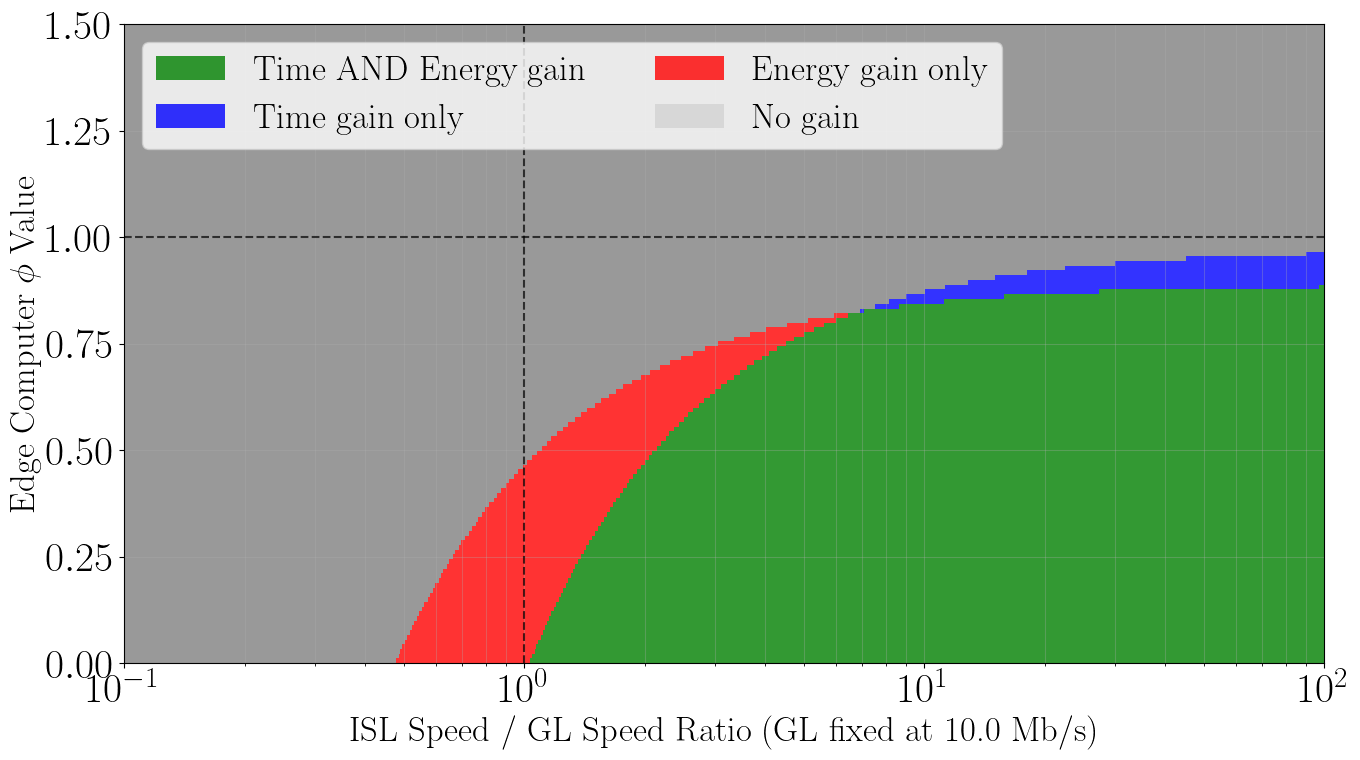

In [89]:
print("Grid computation complete!")
# Classify points based on cost comparisons with base case
condition_1 = (time_costs < base_time_cost) & (energy_costs < base_energy_cost)  # Both better
condition_2 = (time_costs < base_time_cost) & (energy_costs > base_energy_cost)  # Time better, energy worse
condition_3 = (time_costs > base_time_cost) & (energy_costs < base_energy_cost)  # Time worse, energy better

print(f"Dataset 1 (both costs < base): {np.sum(condition_1)} points")
print(f"Dataset 2 (time < base, energy > base): {np.sum(condition_2)} points")
print(f"Dataset 3 (time > base, energy < base): {np.sum(condition_3)} points")
print(f"Other points: {np.sum(~(condition_1 | condition_2 | condition_3))} points")
# Create zones plot with logarithmic x-axis
fig, ax = plt.subplots(figsize=(14, 8))

# Create a classification matrix for zones
# 0 = other/worse, 1 = both better (green), 2 = time better/energy worse (blue), 3 = energy better/time worse (red)
zone_matrix = np.zeros_like(ratio_mesh)
zone_matrix[condition_1] = 1  # Both costs < base (green)
zone_matrix[condition_2] = 2  # Time < base, energy > base (blue)
zone_matrix[condition_3] = 3  # Time > base, energy < base (red)

# Create custom colormap

colors = ['gray', 'green', 'blue', 'red']  # 0=gray, 1=green, 2=blue, 3=red
custom_cmap = ListedColormap(colors)

# Use pcolormesh with logarithmic x-axis for proper scaling
mesh = ax.pcolormesh(ratio_mesh, phi_mesh, zone_matrix,
                     cmap=custom_cmap,
                     vmin=0, vmax=3,
                     alpha=0.8,
                     shading='auto')

# Set logarithmic scale for x-axis
ax.set_xscale('log')

if with_legend:
    # Labels and title with LaTeX formatting
    ax.set_xlabel(r'ISL Speed / GL Speed Ratio (GL fixed at {} Mb/s)'.format(base_ground_link_speed), fontsize=25)
    ax.set_ylabel(r'Edge Computer $\phi$ Value', fontsize=25)
    #ax.set_title(r'Cost Analysis Zones vs Edge Computing Efficiency' + '\n' +
    #             r'Base Time: {:.3f}s, Base Energy: {:.3f}J'.format(base_time_cost, base_energy_cost),
    #             fontsize=16)

# Set axis limits
ax.set_xlim(ratios[0], ratios[-1])
ax.set_ylim(phi_values[0], phi_values[-1])

# Create custom legend

legend_elements = [
    Patch(facecolor='green', alpha=0.8, label='Time AND Energy gain'),
    Patch(facecolor='blue', alpha=0.8, label='Time gain only'),
    Patch(facecolor='red', alpha=0.8, label='Energy gain only'),
    Patch(facecolor='lightgray', alpha=0.8, label='No gain')
]
ax.legend(handles=legend_elements, fontsize=25, loc='upper left', ncol=2)

ax.axvline(x=1, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
ax.axhline(y=1, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

# Add grid for better readability
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()


# Export as PNG and PGF with error handling
def safe_save_figure(fig, base_name, formats=['png', 'pgf']):
    """Safely save figure with error handling and timestamp fallback"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    saved_files = []

    for fmt in formats:
        filename = f"{base_name}.{fmt}"
        backup_filename = f"{base_name}_{timestamp}.{fmt}"

        try:
            if fmt == 'png':
                fig.savefig(filename, dpi=300, bbox_inches='tight', format=fmt)
            elif fmt == 'pgf':
                fig.savefig(filename, bbox_inches='tight', format=fmt)
            else:
                fig.savefig(filename, bbox_inches='tight', format=fmt)
            saved_files.append(filename)
            print(f"✓ Saved: {filename}")
        except PermissionError:
            try:
                # Try with timestamp
                if fmt == 'png':
                    fig.savefig(backup_filename, dpi=300, bbox_inches='tight', format=fmt)
                elif fmt == 'pgf':
                    fig.savefig(backup_filename, bbox_inches='tight', format=fmt)
                else:
                    fig.savefig(backup_filename, bbox_inches='tight', format=fmt)
                saved_files.append(backup_filename)
                print(f"⚠ File was locked, saved as: {backup_filename}")
            except Exception as e:
                print(f"✗ Failed to save {fmt} format: {str(e)}")
        except Exception as e:
            print(f"✗ Failed to save {filename}: {str(e)}")

    return saved_files


# Save the zones plot
saved_files = safe_save_figure(plt.gcf(), 'partial_offloading', formats=['png'])
print(f"Zones plot export complete. Files saved: {', '.join(saved_files)}")

plt.show()